<a href="https://colab.research.google.com/github/sekihiro/Colabo/blob/master/HighResolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 高解像度化

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!nvidia-smi
print('\n')
!nvcc -V
print('\n')
!cat /usr/include/cudnn.h | grep CUDNN_MAJOR -A 2

Mon Feb 10 14:23:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
 # CPUプロセッサ数の確認 (/proc/cpuinfoの行数がプロセッサ数)
 %cat /proc/cpuinfo | grep processor | wc -l

2


In [0]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as dsets
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models
from torchvision.utils import save_image
import easydict
import time
import math
import random
import os
import cv2
from tqdm import tqdm
import pprint
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import cloudpickle
from IPython.display import Image,display_jpeg,display_png

In [5]:
# select device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device : {}'.format(device))

BASE_PATH = "/content/drive/My Drive/git/faces/"

device : cuda


In [6]:
# 必要なデータは下記サイトから事前にダウンロードしておく
# %cd "/content/drive/My Drive/git/faces/"
# !wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
# !tar xf lfw-deepfunneled.tgz
# !mkdir lfw-deepfunneled/train
# !mkdir lfw-deepfunneled/test
# !mv lfw-deepfunneled/[A-W]* train
# !mv lfw-deepfunneled/[X-Z]* test

#%ls "/content/drive/My Drive/git/faces/train/"* | wc -l
#%ls "/content/drive/My Drive/git/faces/test/"* | wc -l
list_train = glob.glob(BASE_PATH + "train/*/*.jpg", recursive=True)
list_test = glob.glob(BASE_PATH + "test/*/*.jpg", recursive=True)
print(len(list_train))
print(len(list_test))

0
162


In [0]:
# 再現性確保
def seed_everything(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    return seed

In [0]:
# 再現性確保
ret = seed_everything(1234)
print('seed : {}'.format(ret))

seed : 1234


width : 250
height : 250
channels : 3
width : 250
height : 250
channels : 3
width : 250
height : 250
channels : 3


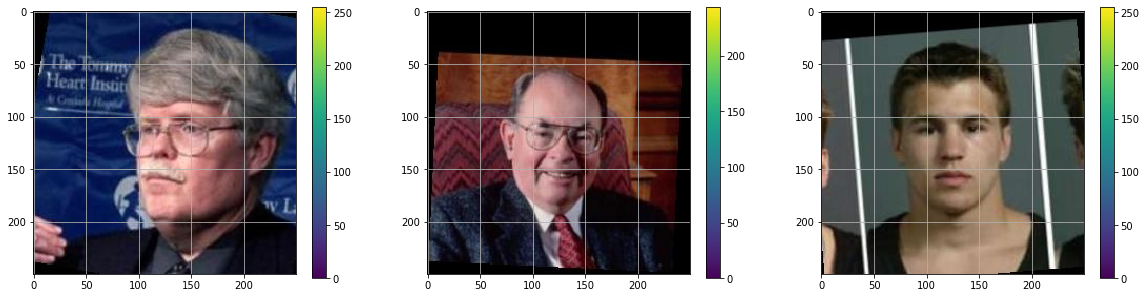

In [8]:
# 画像をピックアップし、おためし表示

# 画像ファイルを読み込み、matplotへ貼り付け
plt.figure(figsize=(20, 5))

im = cv2.imread(BASE_PATH + "train/John_Moe/John_Moe_0001.jpg")
height, width, channels = im.shape[:3]
print("width : " + str(width))
print("height : " + str(height))
print("channels : " + str(channels))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.subplot(1, 3, 1)
plt.imshow(im)
plt.colorbar()
plt.grid(True)

im = cv2.imread(BASE_PATH + "test/Yale_Kamisar/Yale_Kamisar_0001.jpg")
print("width : " + str(width))
print("height : " + str(height))
print("channels : " + str(channels))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.subplot(1, 3, 2)
plt.imshow(im)
plt.colorbar()
plt.grid(True)

im = cv2.imread(BASE_PATH + "test/Zach_Parise/Zach_Parise_0001.jpg")
print("width : " + str(width))
print("height : " + str(height))
print("channels : " + str(channels))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.subplot(1, 3, 3)
plt.imshow(im)
plt.colorbar()
plt.grid(True)

plt.show()

In [0]:
# 画像を128×128ピクセルと32×32ピクセルにリサイズする
class DownSizedPairImageFolder(ImageFolder):
    def __init__(self, root, transform=None, 
                 large_size=128, small_size=32, **kwds):
        super().__init__(root, transform=transform, **kwds)
        self.large_resizer = transforms.Resize(large_size)
        self.small_resizer = transforms.Resize(small_size)
        
    def __getitem__(self, index):
        # 特殊メソッド
        path, _ = self.imgs[index]
        img = self.loader(path)
        
        # 読み取った画像を128×128ピクセルと32×32ピクセルにリサイズする
        large_img = self.large_resizer(img)
        small_img = self.small_resizer(img)
            
        # その他の変換を適用する
        if self.transform is not None:
            large_img = self.transform(large_img)
            small_img = self.transform(small_img)
        
        # 32ピクセルの画像と128ピクセルの画像を返す
        return small_img, large_img

In [10]:
# DownSizedPairImageFolder関数を使用してDatasetを作成する
# 32ピクセルの画像と128ピクセルの画像のtuple
train_data = DownSizedPairImageFolder(
    BASE_PATH + "train",
    transform=transforms.ToTensor())
test_data = DownSizedPairImageFolder(
    BASE_PATH + "test",
    transform=transforms.ToTensor())

# 訓練用と検証用のDataLoaderを作成
# CPUプロセッサ数は2 (=num_workers)
batch_size = 32
train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2)
test_loader = torch.utils.data.DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2)

print('train_data = ', len(train_data))
print('train_loader = ', len(train_loader))
print('train_loader.dataset = ', len(train_loader.dataset))
print('test_data = ', len(test_data))
print('test_loader = ', len(test_loader))
print('test_loader.dataset = ', len(test_loader.dataset))

KeyboardInterrupt: ignored

In [0]:
# モデルの作成
net = nn.Sequential(
    nn.Conv2d(3, 256, 4,
              stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    nn.Conv2d(256, 512, 4,
              stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(512),
    nn.ConvTranspose2d(512, 256, 4,
                       stride=2, padding=1), # 畳み込みの逆処理
    nn.ReLU(),
    nn.BatchNorm2d(256),
    nn.ConvTranspose2d(256, 128, 4,
                       stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.ConvTranspose2d(128, 64, 4,
                       stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.ConvTranspose2d(64, 3, 4,
                       stride=2, padding=1)
)

#pprint.pprint(net)
net.to(device)

Sequential(
  (0): Conv2d(3, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (10): ReLU()
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (13): ReLU()
  (14): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(

In [0]:
# PSNRの計算
# 画像や音声の復元では、PSNR(Peak signal-to-noise ratio)という指標を使うことが多い
# 2枚の画像がどれだけ相違っているかを表す指標のこと
# 1枚の画像だけをみて、それが画質が良い悪いを判断する指標ではない
# 「相違が小さい」ならばPSNRは「大きく」なり、「相違が大きい」ならばPSNRは「小さく」なる
# 単位はデシベル
# mse：平均二乗誤差(Mean Squared Error)
def psnr(mse, max_v=1.0):
    return 10 * math.log10(max_v**2 / mse)

In [0]:
# 損失関数：ラベル値と予測値の違いを計算するための関数
# MSELoss：平均二乗誤差(mean-squared error)を計算
criterion = nn.MSELoss()
# 最適化関数(勾配法)：損失関数の最小化を解く手法
# Adam(Adaptive moment estimation)：勾配の1次(平均)と2次(分散)のモーメント推定
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [0]:
###  training
print('training start ...\n')
num_epochs = 10 

for epoch in range(num_epochs):
    # initialize each epoch
    train_loss, test_loss = 0, 0
    
    # ======== train_mode ======
    net.train()
    # 32*32画像と128*128画像をtupleで取得
    for i, (images, h_images) in tqdm(enumerate(train_loader), total=len(train_loader), desc="[train]"):  # ミニバッチ回数実行
        images, h_images = images.to(device), h_images.to(device)
        # 毎回バックプロパゲーションの初期値をリセット(勾配リセット)
        optimizer.zero_grad()
        # 順方向の伝播の計算(forwardが呼ばれる)
        outputs = net(images)
        # 損失関数：予測値とラベル値の違いを計算
        loss = criterion(outputs, h_images)
        # train_loss に結果を蓄積
        # item()で、Tensorをintへ
        train_loss += loss.item()
        # 誤差のバックプロパゲーション(逆伝播)で勾配を求める
        loss.backward()
        # バックプロパゲーションで計算した勾配を元に重みを更新
        optimizer.step()
    
    # lossの平均を計算
    avg_train_loss = train_loss / len(train_data)

    # ======== valid_mode ======
    net.eval()
    # torch.no_gradで必要のない計算を停止 パラメータの保存を止める(test時にメモリが溢れてしまうのを防止)
    with torch.no_grad():
      for images, h_images in tqdm(test_loader, total=len(test_loader), desc="[test]"):
          images, h_images = images.to(device), h_images.to(device)
          outputs = net(images)
          loss = criterion(outputs, h_images)
          test_loss += loss.item()
    
    avg_test_loss = test_loss / len(test_data)
    
    # print log
    print('\nEpoch [{}/{}], loss: {:.5f}, test_loss: {:.5f}, train_psnr: {:.5f}, test_psnr: {:.5f}'
                   .format(epoch+1, num_epochs, avg_train_loss, avg_test_loss, psnr(avg_train_loss), psnr(avg_test_loss)))

print('training end ...')

# save model
MODEL_PATH = BASE_PATH + 'model/faces_net.pkl'
with open(MODEL_PATH, 'wb') as f:
    cloudpickle.dump(net, f)
    print('model saved ... {}'.format(MODEL_PATH))

training start ...



[test]: 100%|██████████| 6/6 [00:56<00:00,  9.41s/it]


Epoch [1/10], loss: 0.00140, test_loss: 0.00031, train_psnr: 28.54585, test_psnr: 35.06829



[test]: 100%|██████████| 6/6 [00:00<00:00, 10.11it/s]


Epoch [2/10], loss: 0.00022, test_loss: 0.00024, train_psnr: 36.66392, test_psnr: 36.14839



[test]: 100%|██████████| 6/6 [00:00<00:00, 10.32it/s]


Epoch [3/10], loss: 0.00017, test_loss: 0.00020, train_psnr: 37.82424, test_psnr: 37.05950



[test]: 100%|██████████| 6/6 [00:00<00:00, 10.15it/s]


Epoch [4/10], loss: 0.00014, test_loss: 0.00016, train_psnr: 38.51157, test_psnr: 37.99022



[test]: 100%|██████████| 6/6 [00:00<00:00, 10.13it/s]


Epoch [5/10], loss: 0.00012, test_loss: 0.00010, train_psnr: 39.17688, test_psnr: 40.06396



[test]: 100%|██████████| 6/6 [00:00<00:00,  9.72it/s]


Epoch [6/10], loss: 0.00011, test_loss: 0.00015, train_psnr: 39.45120, test_psnr: 38.10782



[test]: 100%|██████████| 6/6 [00:00<00:00,  9.98it/s]


Epoch [7/10], loss: 0.00010, test_loss: 0.00010, train_psnr: 39.88581, test_psnr: 40.05466



[test]: 100%|██████████| 6/6 [00:00<00:00,  9.85it/s]


Epoch [8/10], loss: 0.00010, test_loss: 0.00009, train_psnr: 39.79080, test_psnr: 40.59598



[test]: 100%|██████████| 6/6 [00:00<00:00, 10.41it/s]


Epoch [9/10], loss: 0.00009, test_loss: 0.00010, train_psnr: 40.30498, test_psnr: 39.87141



[test]: 100%|██████████| 6/6 [00:00<00:00, 10.26it/s]



Epoch [10/10], loss: 0.00009, test_loss: 0.00010, train_psnr: 40.57404, test_psnr: 40.09282
training end ...
model saved ... /content/drive/My Drive/git/faces/model/faces_net.pkl


### testデータを使って画像拡大の精度確認

In [0]:
# model load
MODEL_PATH = BASE_PATH + 'model/faces_net.pkl'
with open(MODEL_PATH, 'rb') as f:
    net = cloudpickle.load(f).to(device)
    print('model loaded ... {}\n'.format(MODEL_PATH))

model loaded ... /content/drive/My Drive/git/faces/model/faces_net.pkl



41
162
<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.Tensor'>


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2404: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


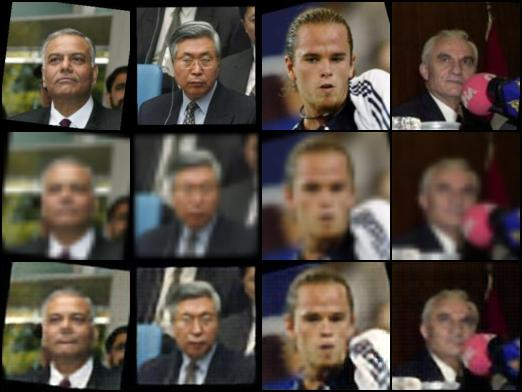

In [0]:
# テストのデータセットからランダムに4つずつ取り出すDataLoader
random_test_loader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=True)
print(len(random_test_loader))
print(len(random_test_loader.dataset))

# DataLoaderをPythonのイテレータに変換し、4つ例を取り出す
print(type(random_test_loader))
# iter()で囲んでからnext()を呼び1バッチ分のデータ(4件)を取り出す
images, h_images = iter(random_test_loader).next()
print(type(images))

# Bilinearで拡大
# 周囲４点の画素値を使って拡大
bl_recon = torch.nn.functional.upsample(images, 128, mode="bilinear", align_corners=True)

# CNNで拡大
# trainしたモデルを使って拡大
pred_images = net(images.to(device))
pred_images = pred_images.to("cpu")

# torch.catで オリジナル(128*128), Bilinear, CNN の画像を結合し
# save_imageで画像ファイルに書き出し
save_image(torch.cat([h_images, bl_recon, pred_images], 0), BASE_PATH + "tmp/cnn_upscale.jpg", nrow=4)

display_jpeg(Image(BASE_PATH + 'tmp/cnn_upscale.jpg'))
os.remove(BASE_PATH + 'tmp/cnn_upscale.jpg')

images : (N, C, H, W) = (1, 3, 32, 32)
h_images : (N, C, H, W) = (1, 3, 128, 128)
pred_images : (N, C, H, W) = (1, 3, 128, 128)
bl_recon : (N, C, H, W) = (1, 3, 128, 128)



/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2404: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


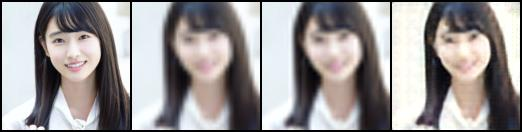

h_images 		 bilinear 	 bicubic 	 net(train->pred)


In [0]:
# 対象画像１枚のみ

wk_data = DownSizedPairImageFolder(
    "/content/drive/My Drive/git/images", # このディレクトリ内のサブディレクトリ配下の画像が対象
    transform=transforms.ToTensor())
wk_loader = torch.utils.data.DataLoader(
        wk_data,
        batch_size=1,
        shuffle=False,
        num_workers=2)
images, h_images = iter(wk_loader).next()
print('images : (N, C, H, W) = {}'.format(images.numpy().shape))
print('h_images : (N, C, H, W) = {}'.format(h_images.numpy().shape))

pred_images = net(images.to(device))
pred_images = pred_images.to("cpu")
print('pred_images : (N, C, H, W) = {}'.format(pred_images.detach().numpy().shape)) # detachで新しいTensorを取得

bl_recon = torch.nn.functional.upsample(images, 128, mode="bilinear", align_corners=True)
print('bl_recon : (N, C, H, W) = {}\n'.format(bl_recon.numpy().shape))

bc_recon = torch.nn.functional.upsample(images, 128, mode="bicubic", align_corners=True)

save_image(torch.cat([h_images, bl_recon, bc_recon, pred_images], 0), BASE_PATH + "tmp/cnn_upscale.jpg", nrow=4)
display_jpeg(Image(BASE_PATH + 'tmp/cnn_upscale.jpg'))
os.remove(BASE_PATH + 'tmp/cnn_upscale.jpg')
print('h_images \t\t bilinear \t bicubic \t net(train->pred)')